Dataset is accessible through: https://drive.google.com/drive/folders/13USe0gzuzmgJxKuQQqGZck3stj5WkY00?usp=sharing

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from llm_classifier_modified import LLMClassifier
from llm_model_modified import LLM
from torch.utils.data import Dataset, DataLoader
from scipy.stats import dirichlet
import evaluation 

In [3]:
# Load youtube comments train and test data
df_train = pd.read_csv('youtube.csv')
n_train = 1100  
n_in_context = 5 
n_total_in_context = 9 * n_in_context  
n_val=100
df_train_actual = df_train.iloc[:n_train] 
df_in_context_base = df_train.iloc[n_train:n_train + n_total_in_context]
df_val = df_train.iloc[n_train + n_total_in_context:n_train+n_total_in_context+n_val]
df_test_actual = df_train.iloc[n_train+n_total_in_context+n_val:]  
gt_labels_train = df_train_actual.iloc[:, 4].values.astype(int) 
samples_train = df_train_actual.iloc[:, 3].values 
gt_labels_val = df_val.iloc[:, 4].values.astype(int) 
samples_val = df_val.iloc[:, 3].values 
gt_labels_test = df_test_actual.iloc[:, 4].values.astype(int)
samples_test = df_test_actual.iloc[:, 3].values 

In [4]:
# Define a prompt formatting class for sentiment classification and initializes an LLM-based classifier
class PromptFormatting(object):
    def __init__(self):
        # Best instruction from BayesPE teacher i.e. instruction with highest weight
        self.INSTRUCTION = 'Judge whether the Youtube comment should be flagged as spam.'
        self.CLASSES = ['not spam', 'spam']
        self.CLASSES_FOR_MATCHING = [self.CLASSES, ['ham', 'spam'], ['0', '1']]
        self.CLASSES_TEXT = '''1. {}\n2. {}'''.format(self.CLASSES[0], self.CLASSES[1])

    def format_instruction(self, instruction):
        return '''{}\n{}\n'''.format(instruction, self.CLASSES_TEXT)

    def format_content(self, content):
        return '''comment: {}\nthe comment is '''.format(content)

llm = LLM(model_name="mistralai/Mistral-7B-Instruct-v0.3", use_reduced_precision=True,use_lora=True)
prompt_formatting = PromptFormatting()
classifier = LLMClassifier(model=llm, prompt_formatting=prompt_formatting)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 14,221,312 || all params: 7,262,244,864 || trainable%: 0.1958


In [6]:
# Load teacher predictions and weights
probs = torch.load("youtube_probs.pt", weights_only=False)
weights = torch.load("youtube_prompt_weights.pt", weights_only=False)
if isinstance(probs, np.ndarray):
    probs = torch.tensor(probs, dtype=torch.float32, device=llm.device)
if isinstance(weights, np.ndarray):
    weights = torch.tensor(weights, dtype=torch.float32, device=llm.device)

In [7]:
print(probs.shape)

torch.Size([1100, 2, 9])


In [8]:
# Compute Dirichlet-based distillation loss
def dirichlet_loss(alpha, probs, weights):
    alpha_0 = torch.sum(alpha, dim=1, keepdim=True)                      
    log_gamma_alpha_0 = torch.lgamma(alpha_0)                           
    log_gamma_alpha_c = torch.lgamma(alpha).sum(dim=1, keepdim=True)   
    alpha_expanded = alpha.unsqueeze(-1)                                
    weighted_log_probs = (alpha_expanded - 1) * torch.log(probs + 1e-8) 
    class_sum = weighted_log_probs.sum(dim=1)                           
    if weights.ndim == 1:
        weights = weights.unsqueeze(1)                                   
    weights_broadcasted = weights.T.expand(probs.shape[0], -1)          
    weighted_terms = class_sum * weights_broadcasted                  
    prompt_sum = weighted_terms.sum(dim=1, keepdim=True)               
    loss = -(log_gamma_alpha_0 - log_gamma_alpha_c + prompt_sum).mean()
    return loss

In [10]:
from torch.utils.data import Dataset, DataLoader
class DirichletDataset(Dataset):
    def __init__(self, samples, num_samples):
        self.samples = samples
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.samples[idx], idx 

In [12]:
# Train student model with teacher predictions
def train_student(samples_train, probs, weights, num_epochs=10, learning_rate=1e-5, batch_size=32):
    dataset = DirichletDataset(samples_train, len(samples_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, llm.model.parameters()), lr=learning_rate)
    llm.model.train()  

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, (batch_samples, batch_indices) in enumerate(dataloader, start=1):
            batch_indices = batch_indices.to(llm.device)

            batch_probs = probs[batch_indices] 

            optimizer.zero_grad()

            alpha = classifier.soft_labels_batch(input_texts=batch_samples)
            alpha = torch.clamp(alpha, min=1e-3)
            loss = dirichlet_loss(alpha, batch_probs, weights)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        torch.cuda.empty_cache()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")
train_student(samples_train, probs, weights, batch_size=32)

Epoch 1/10, Loss: 232.70534297078848
Epoch 2/10, Loss: -2.0872142389416695
Epoch 3/10, Loss: -16.01697575300932
Epoch 4/10, Loss: -27.45224839448929
Epoch 5/10, Loss: -35.714713990688324
Epoch 6/10, Loss: -41.53457850217819
Epoch 7/10, Loss: -45.16400510072708
Epoch 8/10, Loss: -48.006402015686035
Epoch 9/10, Loss: -51.24300092458725
Epoch 10/10, Loss: -54.72450923919678


In [13]:
# Evaluate performance of model on youtube comments test data
def dirichlet_to_prob(alpha):
    return alpha / alpha.sum(dim=1, keepdim=True) 

class DirichletDataset(Dataset):
    def __init__(self, samples, n_samples):
        self.samples = samples
        self.n_samples = n_samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.samples[idx]

llm.model.eval()
test_dataset = DirichletDataset(samples_test, 711)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

def get_test_alpha(test_dataloader, classifier):
    all_alpha = []

    with torch.no_grad():
        for batch_samples in test_dataloader:
            alpha_batch = classifier.soft_labels_batch(input_texts=batch_samples)
            all_alpha.append(alpha_batch)

    return torch.cat(all_alpha, dim=0) 


alpha_test = get_test_alpha(test_dataloader, classifier)
stu_probs = dirichlet_to_prob(alpha_test)

In [14]:
import evaluation  
stu_probs = stu_probs.cpu().numpy()
f1_score = evaluation.compute_metric(gt_labels_test, stu_probs, metric='f1')
ece = evaluation.compute_metric(gt_labels_test, stu_probs, metric='ece')
print('f1-score: {}, ECE: {}'.format(f1_score, ece))

f1-score: 0.8888572293555108, ECE: 0.026875995099544525


In [4]:
# Performance comparison for different values of alpha0(fixed) during training
results = {
    0.01: {
        "f1": [0.7355660496842715, 0.7309390373560629, 0.7354529742186375, 0.7228014469453377, 0.727742949536585],
        "ece": [0.23486006259918213, 0.22925496101379395, 0.23361462354660034, 0.22222065925598145, 0.22643762826919556]
    },
    0.1: {
        "f1": [0.8973203952639544, 0.8888880097009596, 0.8945147679324894, 0.8987323743056546, 0.8830816841246035],
        "ece": [0.34598976373672485, 0.33731842041015625, 0.3428042531013489, 0.3461360037326813, 0.33496585488319397]
    },
    1: {
        "f1": [0.8987339768950784, 0.9001398568198498, 0.9015469219813261, 0.8987291689746308, 0.9015469219813261],
        "ece": [0.11930756270885468, 0.12072303146123886, 0.12133421748876572, 0.11597556620836258, 0.11901257932186127]
    },
    10: {
        "f1": [0.90997150997151, 0.9043280723139515, 0.908567890048016, 0.9015453639082751, 0.8958468604006651],
        "ece": [0.02208564430475235, 0.012523197568953037, 0.017624657601118088, 0.02254198119044304, 0.021961094811558723]
    },
    100: {
        "f1": [0.9001398568198498, 0.9071581196581197, 0.90014064697609, 0.904355326253818, 0.9085787421590175],
        "ece": [0.03775908425450325, 0.035322483628988266, 0.03300410136580467, 0.044156987220048904, 0.03805641829967499]
    },
    1000: {
        "f1": [0.9057665260196905, 0.8959045584045584, 0.9099857572400696, 0.8914820107949106, 0.9000900517550197],
        "ece": [0.03272157907485962, 0.023961491882801056, 0.027477752417325974, 0.02517714537680149, 0.020137861371040344]
    }
}

# Print mean ± variance
for alpha, vals in results.items():
    f1_mean = np.mean(vals["f1"])
    f1_var = np.var(vals["f1"], ddof=1)
    ece_mean = np.mean(vals["ece"])
    ece_var = np.var(vals["ece"], ddof=1)
    
    print(f"alpha_0 = {alpha}")
    print(f" F1-score: {f1_mean:.4f} ± {f1_var:.6f}")
    print(f" ECE     : {ece_mean:.4f} ± {ece_var:.6f}")
    print()


alpha_0 = 0.01
 F1-score: 0.7305 ± 0.000029
 ECE     : 0.2293 ± 0.000027

alpha_0 = 0.1
 F1-score: 0.8925 ± 0.000042
 ECE     : 0.3414 ± 0.000026

alpha_0 = 1
 F1-score: 0.9001 ± 0.000002
 ECE     : 0.1193 ± 0.000004

alpha_0 = 10
 F1-score: 0.9041 ± 0.000032
 ECE     : 0.0193 ± 0.000019

alpha_0 = 100
 F1-score: 0.9041 ± 0.000015
 ECE     : 0.0377 ± 0.000017

alpha_0 = 1000
 F1-score: 0.9006 ± 0.000055
 ECE     : 0.0259 ± 0.000022



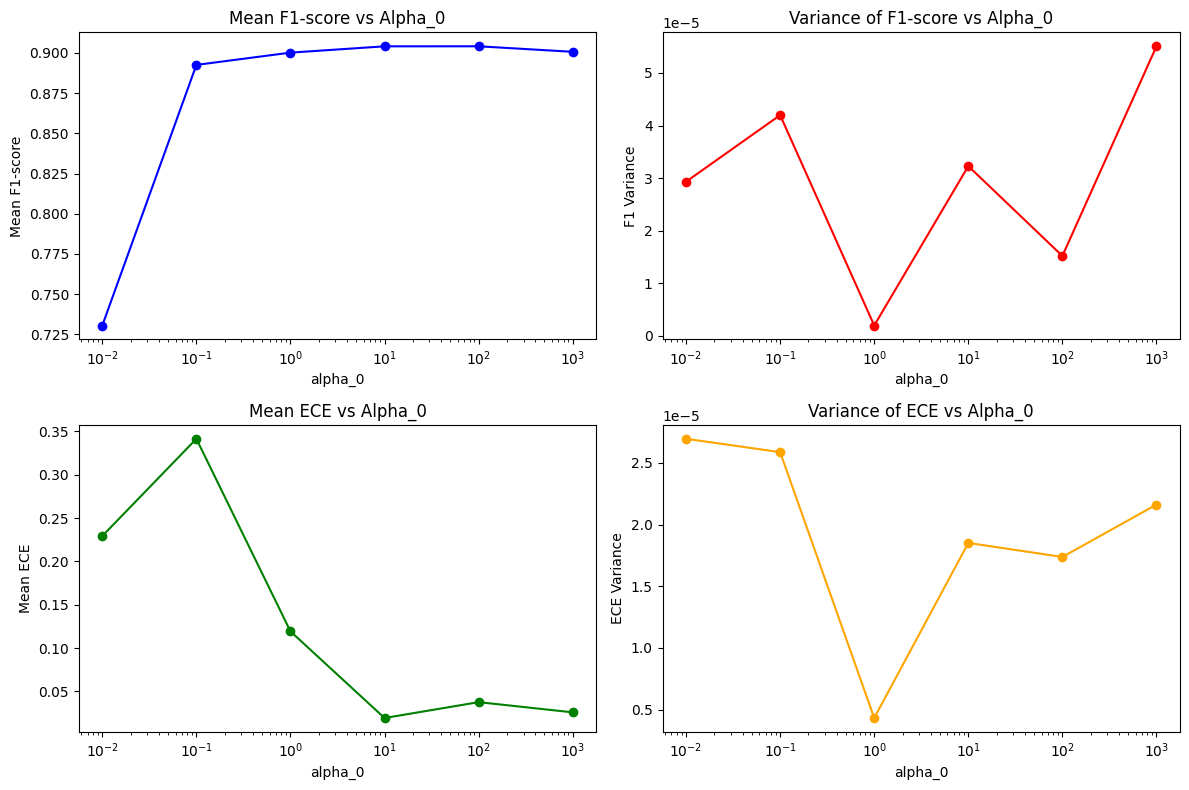

In [8]:
# Plots of (f1-score vs alpha0) & (ECE vs alpha0) for different values of alpha0(fixed) during training
import matplotlib.pyplot as plt
import numpy as np

# Compute statistics
alpha_vals = sorted(results.keys())
f1_means = [np.mean(results[a]["f1"]) for a in alpha_vals]
f1_vars = [np.var(results[a]["f1"], ddof=1) for a in alpha_vals]
ece_means = [np.mean(results[a]["ece"]) for a in alpha_vals]
ece_vars = [np.var(results[a]["ece"], ddof=1) for a in alpha_vals]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

axs[0].plot(alpha_vals, f1_means, marker='o', color='blue')
axs[0].set_title("Mean F1-score vs Alpha_0")
axs[0].set_xlabel("alpha_0")
axs[0].set_ylabel("Mean F1-score")
axs[0].set_xscale('log')

axs[1].plot(alpha_vals, f1_vars, marker='o', color='red')
axs[1].set_title("Variance of F1-score vs Alpha_0")
axs[1].set_xlabel("alpha_0")
axs[1].set_ylabel("F1 Variance")
axs[1].set_xscale('log')

axs[2].plot(alpha_vals, ece_means, marker='o', color='green')
axs[2].set_title("Mean ECE vs Alpha_0")
axs[2].set_xlabel("alpha_0")
axs[2].set_ylabel("Mean ECE")
axs[2].set_xscale('log')

axs[3].plot(alpha_vals, ece_vars, marker='o', color='orange')
axs[3].set_title("Variance of ECE vs Alpha_0")
axs[3].set_xlabel("alpha_0")
axs[3].set_ylabel("ECE Variance")
axs[3].set_xscale('log')

plt.tight_layout()
plt.show()

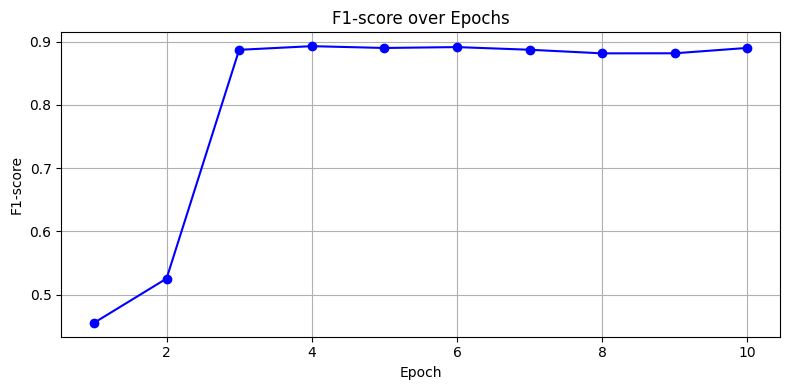

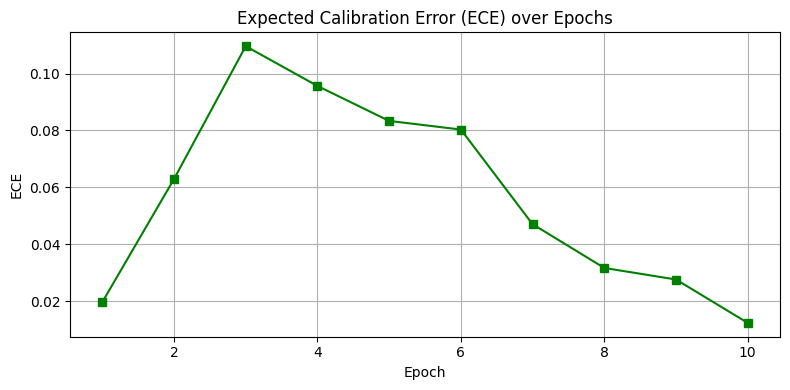

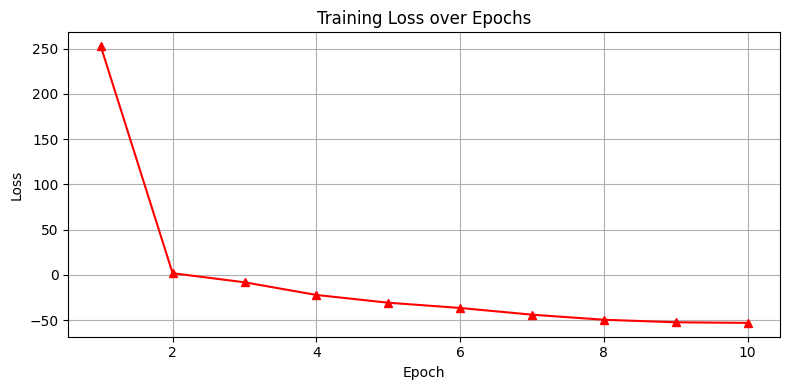

In [3]:
# Plots comparing performance of model of test data over the epochs
import matplotlib.pyplot as plt
epochs = list(range(1, 11))
f1_scores = [
    0.45536074357152456,
    0.525439445250766,
    0.887268114793087,
    0.8930471545745321,
    0.890199572344975,
    0.8915980413316251,
    0.887384176764077,
    0.8816859221223792,
    0.8817889603192197,
    0.8902934054977923
]
ece_scores = [
    0.01959836855530739,
    0.06292768567800522,
    0.10966277122497559,
    0.09566424787044525,
    0.08336193114519119,
    0.08032730221748352,
    0.04703129827976227,
    0.03163839876651764,
    0.027571314945816994,
    0.01231005135923624
]
losses = [
    252.81316759809852,
    1.7590645944001153,
    -8.255443973001093,
    -22.26151493191719,
    -30.850462079048157,
    -36.65599852800369,
    -44.07678246498108,
    -49.67468446493149,
    -52.48085141181946,
    -53.146500647068024
]

# Plot F1-score
plt.figure(figsize=(8, 4))
plt.plot(epochs, f1_scores, marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('F1-score over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot ECE
plt.figure(figsize=(8, 4))
plt.plot(epochs, ece_scores, marker='s', color='green')
plt.xlabel('Epoch')
plt.ylabel('ECE')
plt.title('Expected Calibration Error (ECE) over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(epochs, losses, marker='^', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# Performance of student(different initializations) with worst instruction
import numpy as np

f1_scores = [
    0.9001374862761001,
    0.8987339768950784,
    0.9155234142323047,
    0.9057545943571856,
    0.902934385393563
]

ece_values = [
    0.05091239884495735,
    0.03502875193953514,
    0.06736059486865997,
    0.039051301777362823,
    0.05978892743587494
]

# Compute mean and variance
f1_mean = np.mean(f1_scores)
f1_var = np.var(f1_scores)

ece_mean = np.mean(ece_values)
ece_var = np.var(ece_values)

print(f"F1-score: {f1_mean:.4f} ± {f1_var:.5f}")
print(f"ECE     : {ece_mean:.4f} ± {ece_var:.5f}")


F1-score: 0.9046 ± 0.00004
ECE     : 0.0504 ± 0.00015


In [8]:
# Performance of student(different initializations) with average instruction
import numpy as np

f1_scores = [
    0.8972293119118004,
    0.9015469219813261,
    0.8829954497239103,
    0.8831705670522508,
    0.8915980413316251
]

ece_values = [
    0.051297713071107864,
    0.04700293391942978,
    0.022351760417222977,
    0.018021902069449425,
    0.021343817934393883
]

# Compute mean and variance
f1_mean = np.mean(f1_scores)
f1_var = np.var(f1_scores)

ece_mean = np.mean(ece_values)
ece_var = np.var(ece_values)

print(f"F1-score: {f1_mean:.4f} ± {f1_var:.5f}")
print(f"ECE     : {ece_mean:.4f} ± {ece_var:.5f}")


F1-score: 0.8913 ± 0.00006
ECE     : 0.0320 ± 0.00020


In [9]:
# Performance of student(different initializations) with best instruction
import numpy as np

f1_scores = [
    0.8944847114134598,
    0.8973073932424652,
    0.8859234022323683,
    0.8888572293555108,
    0.8916598228862613
]

ece_values = [
    0.01532716304063797,
    0.01729551889002323,
    0.017324717715382576,
    0.026875995099544525,
    0.010215429589152336
]

# Compute mean and variance
f1_mean = np.mean(f1_scores)
f1_var = np.var(f1_scores)

ece_mean = np.mean(ece_values)
ece_var = np.var(ece_values)

print(f"F1-score: {f1_mean:.4f} ± {f1_var:.5f}")
print(f"ECE     : {ece_mean:.4f} ± {ece_var:.5f}")

F1-score: 0.8916 ± 0.00002
ECE     : 0.0174 ± 0.00003
